# Unsupervised Machine Learning on 2D Spectra
This notebook shows an unsupervised machine learning approach to understanding 2D spectra. The objective here is not to classify or predict specific outcomes, but to explore patterns, relationships, and structures within the dataset using techniques such as dimensionality reduction and clustering.In the process, this notebook demonstrates the use of Principal Component Analysis (PCA) and t-Distributed Stochastic Neighbor Embedding (t-SNE).

In [1]:
import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm, tqdm_notebook
import random
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
import PIL
from PIL import Image
import re
from sklearn.neighbors import NearestNeighbors
import glob
import matplotlib
import matplotlib.pyplot as plt
import plotly.io as pio
import matplotlib.image as mpimg
import io
import base64
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from ipywidgets import Output
from hetdex_api.elixer_widget_cls import ElixerWidget as EW
from IPython.display import Image as IPImage
#from tqdm.keras import TqdmCallback
import tempfile
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
#import tensorflow as tf
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
#from tensorflow.keras.models import load_model
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from astropy.visualization import ZScaleInterval
import os.path as op
from hetdex_api.config import HDRconfig
import tables
from astropy.table import QTable, Table, Column
import dask.array as da
from dask.distributed import Client
from sklearn.decomposition import IncrementalPCA
warnings.filterwarnings("ignore", message="Configuration file not found")

## Prepare Data
First, we load a machine learning catalog and a source catalog. The source catalog is filtered to select only the detections with certain flags. 

In [114]:
version = '3.0.3'
config = HDRconfig('hdr3')

# Setup the machine learning file 
mlfile = op.join( config.hdr_dir['hdr3'], 'catalogs','ml','detect_ml_3.0.3.h5')
fileh = tables.open_file(mlfile, 'r')

# Set the catalog file 
catfile = op.join(config.hdr_dir['hdr3'], 'catalogs', 'source_catalog_' + version + '.fits')
detects_table = Table.read(catfile)

# Filter out detections 
sel = (detects_table['z_hetdex'] > 1.88)
sel_f=(detects_table['flag_pixmask']==1)*(detects_table['flag_baddet']==1)*(detects_table['flag_badamp']==1)*(detects_table['flag_badpix']==1)*(detects_table['flag_badfib']==1)*(detects_table['flag_chi2fib']==1)*(detects_table['flag_meteor']==1)*(detects_table['flag_largegal']==1)*(detects_table['flag_seldet']==1)
#sel_lw = (detects_table['linewidth'] > 8)
#sel_lw = (detects_table['linewidth'] > 6.5) * (detects_table['linewidth'] <= 8) 
sel_lw=(detects_table['linewidth']>=9) * (detects_table['linewidth']<=12)
sel_w=(detects_table['wave']<3550)
sel_lum=(detects_table['lum_lya']<3.0e42)*(detects_table['lum_lya']>1e40)
#sel3 = (detects_table['sn'] > 7) #* (detects_table['sn'] <= 6.5)
sel=sel*sel_f*sel_lw#*sel3

detect_list = detects_table['detectid'][sel] 
print('Number of objects: '+str(len(detect_list)))


Number of objects: 12189


## Image Processing
Then we perform image processing. First, a batch size and the total number of detections are defined. Images are processed in batches. The 'wave' and 'im_sum' values are retrieved, stacked into an array, and normalized. The normalized arrays is then converted to an image and stored in the images list. The process continues until the desired number of images has been processed. Finally, the arrays are flattened and saved into a pickle file along with their filenames. You might notice that there is some redundancy in the loop but this helped me better understand what is happening to the data.

In [115]:
batch_size = 100000
total_detects = len(detect_list)

# Initialize counter for the images and image containers
counter = 0
num_images = 100000
image_filenames = []
images = [] 
count = 0


with open('imfilelist.pkl', 'rb') as f:
    imdict = pickle.load(f)
    
imdict['id']= [str(np.int64(x)) for x in imdict['id']]
images += imdict['fib2d']
image_filenames += imdict['id']


# Loop through the batches of detects
for batch_start in range(0, total_detects, batch_size):
    batch_detects = detect_list[batch_start:batch_start + batch_size]
    
    # Loop through detects within the batch
    for d in tqdm(batch_detects, desc="Processing detects"):
        try:
            # Read the object data from the FiberImages table
            obj_data = fileh.root.FiberImages.read_where('detectid == d')[0]
        except IndexError:
            #print(d)
            # Skip this iteration if the detectid is not found in the FiberImages table
            continue

        # Retrieve object data
        detectid = obj_data['detectid']
        wave = obj_data['im_wave']
        im_sum = obj_data['im_sum']
        #print(len(im_sum[1]))

        # Create an array and normalize it
        arr = np.vstack((wave, im_sum)) #########IMPORTANT
        arr=arr[1:]
        arr = arr - np.min(arr) 
        arr = arr / np.max(arr)  
        arr = arr * 255 
        
        # Convert the array to an image and store it in the images list
        img = Image.fromarray(arr.astype(np.uint8)).convert('L')
        img_arr = np.asarray(img)
        
        # Break the loop if the number of images reached the desired number
        if count >= num_images:
            break
        
        # Store the image filename
        image_filenames.append(str(detectid) + '.png')

        # Add the image to the list
        images.append(img_arr)
        count += 1

    # Break the loop if the number of images reached the desired number
    if count >= num_images:
        break
        
# with open('imfilelist.pkl', 'rb') as f:
#     detid,ra,dec,wave,shot,fib2d = pickle.load(f)
    
# with open('imfilelist.pkl', 'rb') as f:
#     imdict = pickle.load(f)
    
# imdict['id']= [str(np.int64(x)) for x in imdict['id']]
# images += imdict['fib2d']
# image_filenames += imdict['id']
        

# Normalize the images and flatten them
images = np.array(images)
images_normalized = images.astype(np.float32) / 255.0
flattenend_images = np.array([i.flatten() for i in images_normalized])

# Save the flattened images and their filenames into a pickle file
#with open('test.pickle', 'wb') as f:
#    pickle.dump((flattenend_images, image_filenames), f)


Processing detects: 100%|██████████| 12189/12189 [01:23<00:00, 145.36it/s]


In [116]:
len(image_filenames)

11847

In [117]:
len(imdict['fib2d'][0][7])

100

## PCA Fitting

Then by using a PCA fit to the flattened arrays, we calculate the cumulative explained variance. This step is only helpful if you think the number of components in your input is very large and you would be okay to lose a few percent of your input info in trade of faster computation.


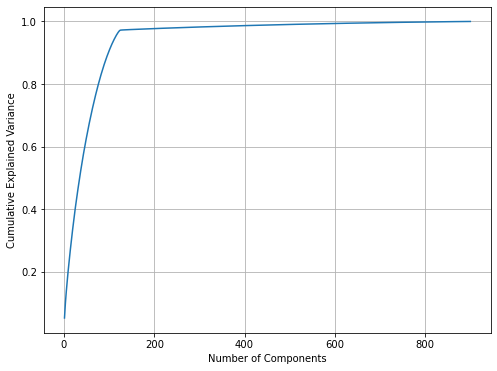

In [118]:
%matplotlib inline

# Load the flattened images and their filenames from the pickle file
#with open('test.pickle', 'rb') as f:
#    flattenend_images, image_filenames = pickle.load(f)

# Perform PCA
pca = PCA()
pca.fit(flattenend_images)

# Calculate cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

## t-SNE & Dimension Reduction 
Now that we know how many components we want to use, we can proceed to feed the input into t-SNE. A dask array is created from the flattened images and divided into chunks. Incremental PCA is performed on each chunk of the dask array, and the results are stored in the reduced_images array. Then, t-SNE is performed on the PCA-transformed images. The t-SNE results are saved into a pickle file. But again, if you think you can use all of your components without running to memory issues, you can ignore the PCA part of the code and just feed your input into t-SNE directly.

In [119]:
# Setup the dask client
client = Client()

# Load the flattened images and their filenames from the pickle file
#with open('test.pickle', 'rb') as f:
#    flattenend_images, image_filenames = pickle.load(f)

# Create a dask array from the flattened images
dask_images = da.from_array(flattenend_images, chunks=(20000, -1))

# Specify the number of components for PCA
n_components_pca = 150
ipca = IncrementalPCA(n_components=n_components_pca)
# Initialize an empty array to store the PCA-transformed images
reduced_images = np.empty((0, n_components_pca))

# Loop through chunks of the dask array
for chunk in dask_images.to_delayed().flatten():
    chunk_np = chunk.compute()

    # Perform PCA on the chunk and add it to the reduced_images array
    reduced_chunk = ipca.partial_fit(chunk_np).transform(chunk_np)
    reduced_images = np.vstack([reduced_images, reduced_chunk])

# Perform t-SNE on the PCA-transformed images
time_start = time.time()
n_components = 2 #3 FOR 3d PLOT
verbose = 1
perplexity = 30 #30 before
n_iter = 1000
metric = 'euclidean'
tsne_results = TSNE(n_components=n_components,
                    verbose=verbose,
                    perplexity=perplexity,
                    n_iter=n_iter,
                    metric=metric).fit_transform(reduced_images)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))
print(f"Number of data points in the plot: {len(tsne_results)}")

# Save the t-SNE results and image filenames into a pickle file
#with open('test_tsne.pickle', 'wb') as f:
#    pickle.dump((tsne_results, image_filenames), f)

client.close()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11847 samples in 0.001s...
[t-SNE] Computed neighbors for 11847 samples in 0.878s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11847
[t-SNE] Computed conditional probabilities for sample 2000 / 11847
[t-SNE] Computed conditional probabilities for sample 3000 / 11847
[t-SNE] Computed conditional probabilities for sample 4000 / 11847
[t-SNE] Computed conditional probabilities for sample 5000 / 11847
[t-SNE] Computed conditional probabilities for sample 6000 / 11847
[t-SNE] Computed conditional probabilities for sample 7000 / 11847
[t-SNE] Computed conditional probabilities for sample 8000 / 11847
[t-SNE] Computed conditional probabilities for sample 9000 / 11847
[t-SNE] Computed conditional probabilities for sample 10000 / 11847
[t-SNE] Computed conditional probabilities for sample 11000 / 11847
[t-SNE] Computed conditional probabilities for sample 11847 / 11847
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence

## Plotting
Lastly, t-SNE results and image filenames are loaded from a pickle file and a scatter plot is created. An event handler for click events is set up to display information about the data points if needed, and an event handler for box selection events is set up to print out the detect IDs of the selected points.

In [120]:
# Load the t-SNE results and image filenames from the pickle file
#with open('test_tsne.pickle', 'rb') as f:
#    tsne_results, image_filenames = pickle.load(f)


'''
this chunk is where the 3d plot works
'''

# Create a DataFrame from the t-SNE results and image filenames
data = {'tsne_0': tsne_results[:, 0], 'tsne_1': tsne_results[:, 1],'tsne_2': tsne_results[:, 2], 'detectid': image_filenames} #ADD Z COMPONET
df = pd.DataFrame(data)

np.savetxt('arr1.txt',tsne_results[:, 0],fmt='%f')
np.savetxt('arr2.txt',tsne_results[:, 1],fmt='%f')
np.savetxt('arr3.txt',tsne_results[:, 2],fmt='%f')
np.savetxt('arr4.txt',image_filenames,fmt='%s')

# Convert the filenames to detectid values
detectid_values = [int(filename.split('/')[-1].split('.')[0]) for filename in image_filenames]
df['detectid_values'] = detectid_values

# Create a scatter plot of the t-SNE results
fig = px.scatter_3d(df, x="tsne_0", y="tsne_1",z="tsne_2")
fig.update_traces(
    marker=dict(size=1.5, color='darkolivegreen'),
    hovertemplate="<b>Detect ID:</b> %{customdata}<br>",
)
output_widget = widgets.Output(layout=widgets.Layout(height='1000px', width="100%",length='100%'))
fig.update_layout(width=700, height=700)#, length=700)

# Define click and selection event handlers
def on_click(trace, points, state):
    point_index = points.point_inds[0]
    custom_data = trace.customdata[point_index]
    image_id = custom_data
    with output_widget:
        clear_output()
        display(EW(detectlist=[int(image_id)]))
def on_box_selection(trace, points, selector):
    selected_points = points.point_inds
    selected_data = trace.customdata[selected_points]
    detect_ids = [int(customdata) for customdata in selected_data]
    print("Selected detect IDs:", detect_ids)

# Create a FigureWidget from the figure and attach the event handlers
fig_widget = go.FigureWidget(fig)
fig_widget.data[0].on_click(on_click)
fig_widget.data[0].on_selection(on_box_selection)
fig_widget.data[0].customdata = df["detectid_values"]

# Display the FigureWidget and the output widget
display(fig_widget)
display(output_widget)


IndexError: index 2 is out of bounds for axis 1 with size 2

In [121]:
data = {'tsne_0': tsne_results[:, 0], 'tsne_1': tsne_results[:, 1], 'detectid': image_filenames} #ADD Z COMPONET
df = pd.DataFrame(data)

np.savetxt('arr1.txt',tsne_results[:, 0],fmt='%f')
np.savetxt('arr2.txt',tsne_results[:, 1],fmt='%f')
#np.savetxt('arr3.txt',tsne_results[:, 2],fmt='%f')
np.savetxt('arr3.txt',image_filenames,fmt='%s')

# Convert the filenames to detectid values
detectid_values = [int(filename.split('/')[-1].split('.')[0]) for filename in image_filenames]
df['detectid_values'] = detectid_values

# Create a scatter plot of the t-SNE results
#fig = px.scatter(df, x="tsne_0", y="tsne_1")#,z="tsne_2")

df1 = df[df['detectid_values'] > 4000000000]
df2 = df[df['detectid_values'] <= 4000000000]
fig = px.scatter(df, x="tsne_0", y="tsne_1")
trace1 = go.Scatter(x=df1['tsne_0'], 
                          y=df1['tsne_1'],
                          mode='markers',
                          marker=dict(size=7.5, color='darkblue'),
                          customdata=df1['detectid_values'],
                          hovertemplate="<b>Detect ID:</b> %{customdata}<br>")
trace2 = go.Scatter(x=df2['tsne_0'], 
                             y=df2['tsne_1'],
                             mode='markers',
                             marker=dict(size=5.5, color='pink',opacity=0.8),
                             customdata=df2['detectid_values'],
                             hovertemplate="<b>Detect ID:</b> %{customdata}<br>")
fig = go.Figure([trace2, trace1])

output_widget = widgets.Output(layout=widgets.Layout(height='1000px', width="100%"))#,length='100%'))
fig.update_layout(width=700, height=700)#, length=700)

# Define click and selection event handlers
def on_click(trace, points, state):
    point_index = points.point_inds[0]
    custom_data = trace.customdata[point_index]
    image_id = custom_data
    with output_widget:
        clear_output()
        display(EW(detectlist=[int(image_id)]))#,img_dir='/home/jovyan/shared/hdr4/broad/topten/revised_20230703/all_pngs'))
def on_box_selection(trace, points, selector):
    selected_points = points.point_inds
    selected_data = trace.customdata[selected_points]
    detect_ids = [int(customdata) for customdata in selected_data]
    print("Selected detect IDs:", detect_ids)

# Create a FigureWidget from the figure and attach the event handlers
fig_widget = go.FigureWidget(fig)
fig_widget.data[0].on_click(on_click)
fig_widget.data[0].on_selection(on_box_selection)
fig_widget.data[0].customdata = df["detectid_values"]

# Display the FigureWidget and the output widget
display(fig_widget)
display(output_widget)


FigureWidget({
    'data': [{'customdata': array([8150330201939022848, 8149696802058523648, 8149962202179523584, ...,
                                            3013841048,          3013841802,          3013842039]),
              'hovertemplate': '<b>Detect ID:</b> %{customdata}<br>',
              'marker': {'color': 'pink', 'opacity': 0.8, 'size': 5.5},
              'mode': 'markers',
              'type': 'scatter',
              'uid': 'eb5938e4-74b4-454a-af16-04a87d276181',
              'x': array([ 3.28125  , -4.207888 , -0.5772669, ..., -5.476279 , -9.538386 ,
                          -2.1732676], dtype=float32),
              'y': array([ 26.261574 ,  -3.361984 , -30.6672   , ...,  20.987333 ,  -4.2111382,
                           -9.197023 ], dtype=float32)},
             {'customdata': array([8150330201939022848, 8149696802058523648, 8149962202179523584,
                                   8149987401818121216, 8149758802429422592, 8150156702483721216,
                  

Output(layout=Layout(height='1000px', width='100%'))

#### please don't hesitate to message me on Slack for any questions @Mahan Mirza Khanlari

In [ ]:
data = {'tsne_0': tsne_results[:, 0], 'tsne_1': tsne_results[:, 1], 'detectid': image_filenames}

In [15]:
len(image_filenames[3000])

14

In [51]:
(df['detectid_values'][1]) > 1000000000000000000

True

In [41]:
len(image_filenames)

14702

In [54]:
np.sum(df['detectid_values']) / len(df['detectid_values'])

352781705961972.3

In [81]:
df['detectid_values'].dtype

dtype('int64')

In [122]:
!pwd

/home/jovyan/work
